In [ ]:
## Script for removing trajectories, which cross or overlap the area edges.

Loading data from: 2024-04-01_2024-04-30_processed.pkl

Debug Information:
Number of trajectories: 3244

First trajectory:
Type: <class 'shapely.geometry.linestring.LineString'>
Number of points: 131
Longitude type: <class 'float'>
Latitude type: <class 'float'>
Coordinate ranges:
Longitude: -88.584 to -88.501
Latitude: 28.159 to 28.296
Loading data from: 2024-04-01_2024-04-30_processed.pkl

Checking trajectory points:
Longitude range in trajectory: -88.584 to -88.501
Latitude range in trajectory: 28.159 to 28.296
Target bounds - Lon: -90.990 to -88.510, Lat: 28.010 to 29.490
Found 1 longitude points outside bounds

Filtering Statistics:
Initial trajectories: 3244
Trajectories within bounds: 2755
Trajectories removed: 489
Removal percentage: 15.1%

Area Bounds:
Longitude: -90.99 to -88.51
Latitude: 28.01 to 29.49

Mask summary:
True values (trajectories kept): 2755
False values (trajectories filtered): 489

Saved filtered trajectories to: 2024-04-01_2024-04-30_filtered.pkl


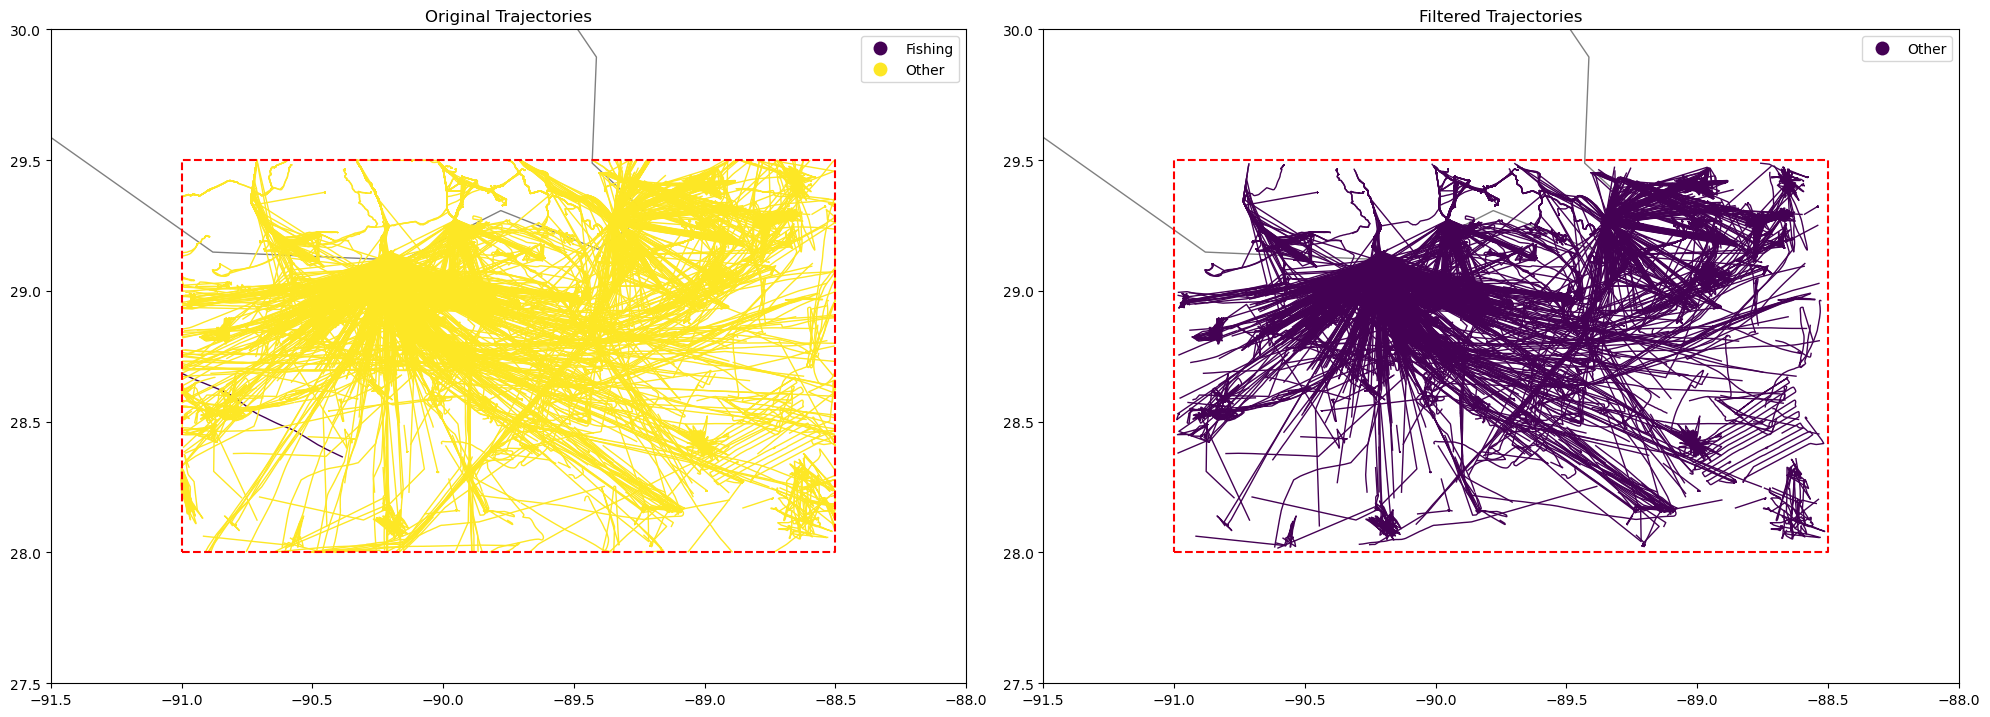

In [10]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from prediction.visualization import plot_north_america, plot_trajectories


def debug_trajectory_data(df: pd.DataFrame):
    """Print debug information about the trajectory data."""
    print("\nDebug Information:")
    print(f"Number of trajectories: {len(df)}")
    
    # Check first trajectory
    first_geom = df.iloc[0]['geometry']
    print("\nFirst trajectory:")
    print(f"Type: {type(first_geom)}")
    lons, lats = first_geom.xy
    print(f"Number of points: {len(lons)}")
    print(f"Longitude type: {type(lons[0])}")
    print(f"Latitude type: {type(lats[0])}")
    print(f"Coordinate ranges:")
    print(f"Longitude: {min(lons):.3f} to {max(lons):.3f}")
    print(f"Latitude: {min(lats):.3f} to {max(lats):.3f}")



def filter_trajectories_in_bounds(df: pd.DataFrame,
                                lon_min: float,
                                lon_max: float,
                                lat_min: float,
                                lat_max: float,
                                verbose: bool = True) -> pd.DataFrame:
    """
    Filter trajectories to only keep those that stay completely within specified bounds.
    Removes any trajectories that cross boundaries or go outside the area.
    """
    initial_count = len(df)
    first_trajectory = True  # Use this instead of modifying verbose
    
    def trajectory_stays_in_bounds(geom):
        nonlocal first_trajectory
        lons, lats = geom.xy
        
        # Debug printout for first trajectory
        if first_trajectory and len(lons) > 0:
            print("\nChecking trajectory points:")
            print(f"Longitude range in trajectory: {min(lons):.3f} to {max(lons):.3f}")
            print(f"Latitude range in trajectory: {min(lats):.3f} to {max(lats):.3f}")
            print(f"Target bounds - Lon: {lon_min:.3f} to {lon_max:.3f}, Lat: {lat_min:.3f} to {lat_max:.3f}")
            
            # Check if any points are outside bounds
            lon_outside = [lon for lon in lons if lon < lon_min or lon > lon_max]
            lat_outside = [lat for lat in lats if lat < lat_min or lat > lat_max]
            
            if lon_outside:
                print(f"Found {len(lon_outside)} longitude points outside bounds")
            if lat_outside:
                print(f"Found {len(lat_outside)} latitude points outside bounds")
                
            first_trajectory = False  # Only print for first trajectory
            
        return (all(lon_min <= lon <= lon_max for lon in lons) and
                all(lat_min <= lat <= lat_max for lat in lats))
    
    mask = df['geometry'].apply(trajectory_stays_in_bounds)
    filtered_df = df[mask].reset_index(drop=True)
    
    if verbose:
        removed_count = initial_count - len(filtered_df)
        print(f"\nFiltering Statistics:")
        print(f"Initial trajectories: {initial_count}")
        print(f"Trajectories within bounds: {len(filtered_df)}")
        print(f"Trajectories removed: {removed_count}")
        print(f"Removal percentage: {(removed_count/initial_count)*100:.1f}%")
        
        print(f"\nArea Bounds:")
        print(f"Longitude: {lon_min} to {lon_max}")
        print(f"Latitude: {lat_min} to {lat_max}")
        
        # Add check for mask values
        print(f"\nMask summary:")
        print(f"True values (trajectories kept): {mask.sum()}")
        print(f"False values (trajectories filtered): {len(mask) - mask.sum()}")
    
    return filtered_df


def filter_and_save_trajectories(
    input_path: str,
    output_path: str,
    lon_min: float,
    lon_max: float,
    lat_min: float,
    lat_max: float,
    buffer_dist: float = 0.001,  # roughly 100m in decimal degrees
    verbose: bool = True
) -> pd.DataFrame:
    """
    Load data, filter trajectories that stay within bounds and save to pkl file.
    The actual filtering area will be shrunk by buffer_dist from all edges.
    
    Args:
        input_path: Path to input pkl file
        output_path: Path where to save the filtered pkl file
        lon_min: Minimum longitude of target area
        lon_max: Maximum longitude of target area
        lat_min: Minimum latitude of target area
        lat_max: Maximum latitude of target area
        buffer_dist: Distance in decimal degrees to shrink from edges (0.001 ≈ 100m)
        verbose: Whether to print filtering statistics
    """
    # Load the data
    if verbose:
        print(f"Loading data from: {input_path}")
    input_df = pd.read_pickle(input_path)
    
    # Adjust bounds inward by buffer
    filtered_df = filter_trajectories_in_bounds(
        input_df, 
        lon_min=lon_min + buffer_dist,  # shrink from left
        lon_max=lon_max - buffer_dist,  # shrink from right
        lat_min=lat_min + buffer_dist,  # shrink from bottom
        lat_max=lat_max - buffer_dist,  # shrink from top
        verbose=verbose
    )
    
    # Save to pkl
    filtered_df.to_pickle(output_path)
    if verbose:
        print(f"\nSaved filtered trajectories to: {output_path}")
    
    return filtered_df




def visualize_filtering(original_df: pd.DataFrame, 
                       filtered_df: pd.DataFrame,
                       lon_min: float,
                       lon_max: float,
                       lat_min: float,
                       lat_max: float):
    """Visualize the trajectories before and after filtering."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot original data
    ax1.set_title("Original Trajectories")
    plot_north_america(ax1)
    plot_trajectories(original_df, ax1)
    # Draw bounding box
    ax1.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
             [lat_min, lat_min, lat_max, lat_max, lat_min],
             'r--', label='Boundary')
    ax1.set_xlim(lon_min - 0.5, lon_max + 0.5)
    ax1.set_ylim(lat_min - 0.5, lat_max + 0.5)
    
    # Plot filtered data
    ax2.set_title("Filtered Trajectories")
    plot_north_america(ax2)
    plot_trajectories(filtered_df, ax2)
    # Draw bounding box
    ax2.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
             [lat_min, lat_min, lat_max, lat_max, lat_min],
             'r--', label='Boundary')
    ax2.set_xlim(lon_min - 0.5, lon_max + 0.5)
    ax2.set_ylim(lat_min - 0.5, lat_max + 0.5)
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Example filtering workflow
    input_path = "2024-04-01_2024-04-30_processed.pkl"
    output_path = "2024-04-01_2024-04-30_filtered.pkl"
    
    # Load and debug original data
    print(f"Loading data from: {input_path}")
    input_df = pd.read_pickle(input_path)
    debug_trajectory_data(input_df)
    
    # Example usage with original area:
    filtered_df = filter_and_save_trajectories(
        input_path,
        output_path,
        lon_min=-91.0,
        lon_max=-88.5,
        lat_min=28.0,
        lat_max=29.5,
        buffer_dist=0.01
    )
    
    # Visualize the difference
    visualize_filtering(input_df, filtered_df, -91.0, -88.5, 28.00, 29.50)